Scaling down `overall_rating` to 3-class and creates in `satisfaction_class`

In [1]:
import csv

input_file = "/content/drive/MyDrive/PR_Sky/Dataset/lounge.csv"

output_file = "/content/drive/MyDrive/PR_Sky/lounge_with_target.csv"

rows = []
with open(input_file, "r", encoding="utf-8") as f:
    data = csv.DictReader(f)
    for row in data:

        rating = row["overall_rating"]
        try:
            rating = float(rating)
        except:

            continue

        if rating <= 4:
            row["satisfaction_class"] = 0
        elif rating <= 7:
            row["satisfaction_class"] = 1
        else:
            row["satisfaction_class"] = 2

        rows.append(row)

header = list(rows[0].keys())
with open(output_file, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=header)
    writer.writeheader()
    for r in rows:
        writer.writerow(r)

count_0 = 0
count_1 = 0
count_2 = 0

for r in rows:
    if r["satisfaction_class"] == 0:
        count_0 = count_0 + 1
    elif r["satisfaction_class"] == 1:
        count_1 = count_1 + 1
    elif r["satisfaction_class"] == 2:
        count_2 = count_2 + 1

total = count_0 + count_1 + count_2

print("Final dataset shape:", "(", total, ",", len(header), ")")
print("\nClass distribution (counts):")
print("0", count_0)
print("1", count_1)
print("2", count_2)
print("\nClass distribution (proportion):")

if total > 0:
    print("0", round(count_0 / total, 3))
    print("1", round(count_1 / total, 3))
    print("2", round(count_2 / total, 3))
else:
    print("no data to calculate")

print("\nSaved:", output_file)

Final dataset shape: ( 2259 , 22 )

Class distribution (counts):
0 1823
1 388
2 48

Class distribution (proportion):
0 0.807
1 0.172
2 0.021

Saved: /content/drive/MyDrive/PR_Sky/lounge_with_target.csv


# Path way to Gaussian Naive Bayes

Load & sanity check (NO training yet)

In [2]:
import csv

BASE = "/content/drive/MyDrive/PR_Sky"
IN_CSV = BASE + "/lounge_with_target.csv"
OUT_CSV = BASE + "/lounge_with_target__checked.csv"

rows = []
with open(IN_CSV, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    header = r.fieldnames
    for row in r:
        rows.append(row)

row_count = len(rows)
col_count = len(header) if header else 0
print("Shape:", (row_count, col_count))
print("Columns:", list(header) if header else [])

has_target = False
for col in header:
    if col == "satisfaction_class":
        has_target = True
        break

if not has_target:
    print("satisfaction_class not found. Create it from overall_rating before this step.")
    raise SystemExit(0)

clean_rows = []
for row in rows:
    v = row.get("satisfaction_class", "")
    ok = True
    try:
        vv = float(v)

        if vv == int(vv):
            vv = int(vv)
        else:
            ok = False
    except:
        ok = False

    if ok and (vv == 0 or vv == 1 or vv == 2):
        row["satisfaction_class"] = vv
        clean_rows.append(row)
    else:

        pass

rows = clean_rows
row_count = len(rows)

print("\nClass distribution (counts):")
c0 = 0
c1 = 0
c2 = 0
for row in rows:
    if row["satisfaction_class"] == 0:
        c0 = c0 + 1
    elif row["satisfaction_class"] == 1:
        c1 = c1 + 1
    elif row["satisfaction_class"] == 2:
        c2 = c2 + 1

print("0", c0)
print("1", c1)
print("2", c2)

print("\nClass distribution (proportions):")
total = c0 + c1 + c2
if total > 0:
    p0 = round(c0 / total, 3)
    p1 = round(c1 / total, 3)
    p2 = round(c2 / total, 3)
    print("0", p0)
    print("1", p1)
    print("2", p2)
else:
    print("0", 0.0)
    print("1", 0.0)
    print("2", 0.0)

numeric_feature_candidates = [
    "comfort_rating",
    "cleanliness_rating",
    "bar_beverages_rating",
    "catering_rating",
    "washrooms_rating",
    "wifi_connectivity_rating",
    "staff_service_rating",
]

numeric_cols = []
for name in numeric_feature_candidates:
    for col in header:
        if col == name:
            numeric_cols.append(name)
            break

if len(numeric_cols) == 0:
    print("No numeric rating features found. Check your dataset columns.")
    raise SystemExit(0)

for row in rows:
    for col in numeric_cols:
        txt = row.get(col, "")
        try:
            row[col] = float(txt)
        except:
            row[col] = None

print("\nNumeric features to use (excluding overall_rating):", numeric_cols)

miss_list = []
for col in numeric_cols:
    miss_cnt = 0
    for row in rows:
        if row[col] is None:
            miss_cnt = miss_cnt + 1
    pct = 0.0
    if row_count > 0:
        pct = miss_cnt / row_count
    miss_list.append((col, pct))

miss_list = sorted(miss_list, key=lambda x: x[1], reverse=True)

print("\nMissingness (numeric features):")

for item in miss_list:
    col, pct = item
    print(col, round(pct, 3))

high_missing = []
for col, pct in miss_list:
    if pct > 0.5:
        high_missing.append(col)

if len(high_missing) > 0:
    print("\nNOTE: These features have >50% missing values and may hurt GNB:")
    print(high_missing)
    print("You can drop them or keep with imputation + missingness flags in preprocessing.")

print("\nSample rows (head):")

show_cols = ["satisfaction_class"] + numeric_cols
print(show_cols)

i = 0
for row in rows:
    one = []
    for col in show_cols:
        val = row.get(col, "")

        if val is None:
            one.append("")
        else:
            one.append(val)
    print(one)
    i = i + 1
    if i >= 10:
        break

with open(OUT_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=header)
    w.writeheader()
    for row in rows:
        out_row = {}
        for col in header:
            v = row.get(col, "")
            if v is None:
                v = ""
            out_row[col] = v
        w.writerow(out_row)

print("\nSaved checked dataset to:", OUT_CSV)

Shape: (2259, 22)
Columns: ['airline_name', 'link', 'title', 'author', 'author_country', 'date', 'content', 'lounge_name', 'airport', 'lounge_type', 'date_visit', 'type_traveller', 'overall_rating', 'comfort_rating', 'cleanliness_rating', 'bar_beverages_rating', 'catering_rating', 'washrooms_rating', 'wifi_connectivity_rating', 'staff_service_rating', 'recommended', 'satisfaction_class']

Class distribution (counts):
0 1823
1 388
2 48

Class distribution (proportions):
0 0.807
1 0.172
2 0.021

Numeric features to use (excluding overall_rating): ['comfort_rating', 'cleanliness_rating', 'bar_beverages_rating', 'catering_rating', 'washrooms_rating', 'wifi_connectivity_rating', 'staff_service_rating']

Missingness (numeric features):
washrooms_rating 0.012
wifi_connectivity_rating 0.005
staff_service_rating 0.004
bar_beverages_rating 0.002
catering_rating 0.001
comfort_rating 0.0
cleanliness_rating 0.0

Sample rows (head):
['satisfaction_class', 'comfort_rating', 'cleanliness_rating', 'bar

Preprocessing & Feature Engineering

In [3]:
import os
import csv
import random

BASE = "/content/drive/MyDrive/PR_Sky"
IN_CSV = BASE + "/lounge_with_target__checked.csv"
OUT_DIR = BASE
try:
    os.makedirs(OUT_DIR, exist_ok=True)
except:
    pass

rows = []
with open(IN_CSV, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    header = r.fieldnames
    for row in r:
        rows.append(row)

target = "satisfaction_class"
wanted = [
    "comfort_rating",
    "cleanliness_rating",
    "bar_beverages_rating",
    "catering_rating",
    "washrooms_rating",
    "wifi_connectivity_rating",
    "staff_service_rating",
]

features = []
for c in wanted:
    found = False
    for h in header:
        if h == c:
            found = True
            break
    if found:
        features.append(c)

if len(features) == 0:
    print("No numeric rating features found. Check your dataset columns.")
    raise SystemExit(0)

clean = []
for row in rows:
    v = row.get(target, "")
    ok = True
    try:
        v2 = float(v)
        if v2 == int(v2):
            v2 = int(v2)
        else:
            ok = False
    except:
        ok = False
    if ok and (v2 == 0 or v2 == 1 or v2 == 2):
        row[target] = v2
        clean.append(row)
rows = clean

for row in rows:
    for c in features:
        txt = row.get(c, "")
        try:
            row[c] = float(txt)
        except:
            row[c] = None

c0 = 0
c1 = 0
c2 = 0
for row in rows:
    if row[target] == 0:
        c0 = c0 + 1
    elif row[target] == 1:
        c1 = c1 + 1
    elif row[target] == 2:
        c2 = c2 + 1

print("\nClass distribution (counts):")
print("0", c0)
print("1", c1)
print("2", c2)

total = c0 + c1 + c2
print("\nClass distribution (proportions):")
if total > 0:
    print("0", round(c0 / total, 3))
    print("1", round(c1 / total, 3))
    print("2", round(c2 / total, 3))
else:
    print("0", 0.0)
    print("1", 0.0)
    print("2", 0.0)

medians = {}
for c in features:
    vals = []
    for row in rows:
        v = row[c]
        if v is not None:
            vals.append(v)
    vals.sort()
    if len(vals) == 0:
        med = 0.0
    else:
        n = len(vals)
        mid = n // 2
        if n % 2 == 1:
            med = vals[mid]
        else:
            med = (vals[mid - 1] + vals[mid]) / 2.0
    medians[c] = med

for row in rows:
    for c in features:
        if row[c] is None:
            row[c] = medians[c]

class0 = []
class1 = []
class2 = []
for row in rows:
    if row[target] == 0:
        class0.append(row)
    elif row[target] == 1:
        class1.append(row)
    elif row[target] == 2:
        class2.append(row)

random.seed(42)
random.shuffle(class0)
random.shuffle(class1)
random.shuffle(class2)

def take_split(lst):
    n = len(lst)
    n_test = int(n * 0.20)
    test_part = lst[:n_test]
    train_part = lst[n_test:]
    return train_part, test_part

train0, test0 = take_split(class0)
train1, test1 = take_split(class1)
train2, test2 = take_split(class2)

train_rows = train0 + train1 + train2
test_rows = test0 + test1 + test2

print("\nShapes: X_train:", (len(train_rows), len(features)), "X_test:", (len(test_rows), len(features)))

train_path = OUT_DIR + "/lounge_train_proc.csv"
test_path  = OUT_DIR + "/lounge_test_proc.csv"

with open(train_path, "w", newline="", encoding="utf-8") as f:
    cols = features + [target]
    w = csv.DictWriter(f, fieldnames=cols)
    w.writeheader()
    for row in train_rows:
        out_row = {}
        for c in cols:
            v = row.get(c, "")
            out_row[c] = v
        w.writerow(out_row)

with open(test_path, "w", newline="", encoding="utf-8") as f:
    cols = features + [target]
    w = csv.DictWriter(f, fieldnames=cols)
    w.writeheader()
    for row in test_rows:
        out_row = {}
        for c in cols:
            v = row.get(c, "")
            out_row[c] = v
        w.writerow(out_row)

print("\nSaved preprocessed datasets:")
print(" - Train:", train_path)
print(" - Test :", test_path)


Class distribution (counts):
0 1823
1 388
2 48

Class distribution (proportions):
0 0.807
1 0.172
2 0.021

Shapes: X_train: (1809, 7) X_test: (450, 7)

Saved preprocessed datasets:
 - Train: /content/drive/MyDrive/PR_Sky/lounge_train_proc.csv
 - Test : /content/drive/MyDrive/PR_Sky/lounge_test_proc.csv


Gaussian Naive Bayes

Train shape: (1809, 7)  Test shape: (450, 7)
Classes in y_train: [0, 1, 2]
Classes in y_test : [0, 1, 2]

=== GaussianNB (Lounge) — Test Metrics ===
Accuracy          : 0.8756
Macro F1          : 0.6223
Log-loss          : 0.6090
Brier (multiclass): 0.194426

=== Classification Report ===
              precision    recall  f1-score   support
           0      0.9786    0.8791     0.9262       364
           1      0.6792    0.9351     0.7869        77
           2      0.1176    0.2222     0.1538         9

    accuracy                             0.8756       450
   macro avg      0.5918    0.6788     0.6223       450
weighted avg      0.9102    0.8756     0.8869       450

Confusion Matrix (counts) [rows=true, cols=pred]:
 [[320  29  15]
 [  5  72   0]
 [  2   5   2]]


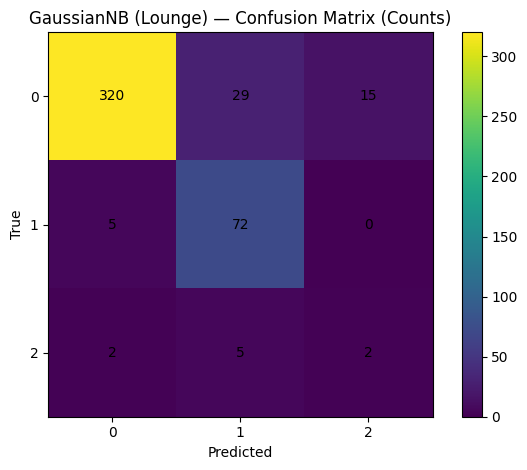

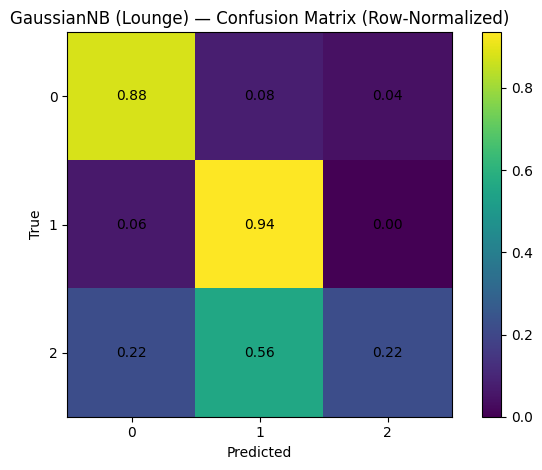

In [6]:
import os
import csv
import math
import numpy as np
import matplotlib.pyplot as plt

BASE_DIR = "/content/drive/MyDrive/PR_Sky"
TRAIN_CSV = BASE_DIR + "/lounge_train_proc.csv"
TEST_CSV  = BASE_DIR + "/lounge_test_proc.csv"

train_rows = []
with open(TRAIN_CSV, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    train_header = r.fieldnames
    for row in r:
        train_rows.append(row)

test_rows = []
with open(TEST_CSV, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    test_header = r.fieldnames
    for row in r:
        test_rows.append(row)

target_col = "satisfaction_class"

features = []
for c in train_header:
    if c != target_col:
        features.append(c)

print("Train shape:", (len(train_rows), len(features)), " Test shape:", (len(test_rows), len(features)))

train_class_set = {}
for row in train_rows:
    yv = int(float(row[target_col]))
    train_class_set[yv] = True

test_class_set = {}
for row in test_rows:
    yv = int(float(row[target_col]))
    test_class_set[yv] = True

y_train_classes = []
y_test_classes = []
for k in [0, 1, 2]:
    if k in train_class_set:
        y_train_classes.append(k)
    if k in test_class_set:
        y_test_classes.append(k)

print("Classes in y_train:", y_train_classes)
print("Classes in y_test :", y_test_classes)

by_class = {0: [], 1: [], 2: []}
for row in train_rows:
    yv = int(float(row[target_col]))
    if yv == 0 or yv == 1 or yv == 2:
        by_class[yv].append(row)

total_train = len(train_rows)
priors = {0: 0.0, 1: 0.0, 2: 0.0}
if total_train > 0:
    priors[0] = len(by_class[0]) / float(total_train)
    priors[1] = len(by_class[1]) / float(total_train)
    priors[2] = len(by_class[2]) / float(total_train)

means = {0: {}, 1: {}, 2: {}}
for c in [0, 1, 2]:
    for f in features:
        s = 0.0
        n = 0
        for row in by_class[c]:
            s = s + float(row[f])
            n = n + 1
        if n == 0:
            m = 0.0
        else:
            m = s / n
        means[c][f] = m

vars_ = {0: {}, 1: {}, 2: {}}
for c in [0, 1, 2]:
    for f in features:
        mu = means[c][f]
        s2 = 0.0
        n = 0
        for row in by_class[c]:
            x = float(row[f])
            d = x - mu
            s2 = s2 + d * d
            n = n + 1
        if n == 0:
            v = 1e-6
        else:
            v = s2 / n
            if v <= 1e-9:
                v = 1e-9
        vars_[c][f] = v

y_true = []
y_pred = []
y_proba = []

for row in test_rows:
    yt = int(float(row[target_col]))
    y_true.append(yt)

    logp0 = math.log(priors[0] if priors[0] > 0 else 1e-12)
    logp1 = math.log(priors[1] if priors[1] > 0 else 1e-12)
    logp2 = math.log(priors[2] if priors[2] > 0 else 1e-12)

    for f in features:
        x = float(row[f])

        mu0 = means[0][f]; v0 = vars_[0][f]
        logp0 = logp0 - 0.5 * math.log(2.0 * math.pi * v0) - ((x - mu0) * (x - mu0)) / (2.0 * v0)

        mu1 = means[1][f]; v1 = vars_[1][f]
        logp1 = logp1 - 0.5 * math.log(2.0 * math.pi * v1) - ((x - mu1) * (x - mu1)) / (2.0 * v1)

        mu2 = means[2][f]; v2 = vars_[2][f]
        logp2 = logp2 - 0.5 * math.log(2.0 * math.pi * v2) - ((x - mu2) * (x - mu2)) / (2.0 * v2)

    mlog = max(logp0, logp1, logp2)
    e0 = math.exp(logp0 - mlog)
    e1 = math.exp(logp1 - mlog)
    e2 = math.exp(logp2 - mlog)
    s = e0 + e1 + e2
    if s == 0.0:
        p0 = 1.0 / 3.0; p1 = 1.0 / 3.0; p2 = 1.0 / 3.0
    else:
        p0 = e0 / s; p1 = e1 / s; p2 = e2 / s
    y_proba.append([p0, p1, p2])

    if p0 >= p1 and p0 >= p2:
        yp = 0
    elif p1 >= p0 and p1 >= p2:
        yp = 1
    else:
        yp = 2
    y_pred.append(yp)

correct = 0
for i in range(len(y_true)):
    if y_true[i] == y_pred[i]:
        correct = correct + 1
if len(y_true) > 0:
    acc = correct / float(len(y_true))
else:
    acc = 0.0

cm = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
for i in range(len(y_true)):
    a = y_true[i]
    b = y_pred[i]
    if a >= 0 and a <= 2 and b >= 0 and b <= 2:
        cm[a][b] = cm[a][b] + 1

precisions = [0.0, 0.0, 0.0]
recalls    = [0.0, 0.0, 0.0]
f1s        = [0.0, 0.0, 0.0]
supports   = [0, 0, 0]

for c in [0, 1, 2]:
    tp = cm[c][c]
    col_sum = cm[0][c] + cm[1][c] + cm[2][c]
    row_sum = cm[c][0] + cm[c][1] + cm[c][2]
    fp = col_sum - tp
    fn = row_sum - tp
    supports[c] = row_sum

    if tp + fp > 0:
        precisions[c] = tp / float(tp + fp)
    else:
        precisions[c] = 0.0
    if tp + fn > 0:
        recalls[c] = tp / float(tp + fn)
    else:
        recalls[c] = 0.0
    if precisions[c] + recalls[c] > 0:
        f1s[c] = 2.0 * precisions[c] * recalls[c] / (precisions[c] + recalls[c])
    else:
        f1s[c] = 0.0

f1_macro = (f1s[0] + f1s[1] + f1s[2]) / 3.0

total_support = supports[0] + supports[1] + supports[2]
if total_support > 0:
    w_prec = (precisions[0]*supports[0] + precisions[1]*supports[1] + precisions[2]*supports[2]) / total_support
    w_rec  = (recalls[0]*supports[0]    + recalls[1]*supports[1]    + recalls[2]*supports[2])    / total_support
    w_f1   = (f1s[0]*supports[0]        + f1s[1]*supports[1]        + f1s[2]*supports[2])        / total_support
else:
    w_prec = 0.0; w_rec = 0.0; w_f1 = 0.0

eps = 1e-15
ll_sum = 0.0
for i in range(len(y_true)):
    t = y_true[i]
    p = y_proba[i][t]
    if p < eps:
        p = eps
    ll_sum = ll_sum + (-math.log(p))
if len(y_true) > 0:
    ll = ll_sum / float(len(y_true))
else:
    ll = 0.0

brier_sum = 0.0
for i in range(len(y_true)):
    t = y_true[i]
    p0, p1, p2 = y_proba[i][0], y_proba[i][1], y_proba[i][2]
    y0 = 1.0 if t == 0 else 0.0
    y1 = 1.0 if t == 1 else 0.0
    y2 = 1.0 if t == 2 else 0.0
    brier_sum = brier_sum + ((p0 - y0)*(p0 - y0) + (p1 - y1)*(p1 - y1) + (p2 - y2)*(p2 - y2))
if len(y_true) > 0:
    brier_multiclass = brier_sum / float(len(y_true))
else:
    brier_multiclass = 0.0

print("\n=== GaussianNB (Lounge) — Test Metrics ===")
print("Accuracy          : %.4f" % acc)
print("Macro F1          : %.4f" % f1_macro)
print("Log-loss          : %.4f" % ll)
print("Brier (multiclass): %.6f" % brier_multiclass)

print("\n=== Classification Report ===")

print("              precision    recall  f1-score   support")
for c in [0, 1, 2]:
    print("{:>12} {:>11.4f} {:>9.4f} {:>10.4f} {:>9d}".format(str(c), precisions[c], recalls[c], f1s[c], supports[c]))

print("\n{:>12} {:>34.4f} {:>9d}".format("accuracy", acc, total_support))

macro_p = (precisions[0] + precisions[1] + precisions[2]) / 3.0
macro_r = (recalls[0] + recalls[1] + recalls[2]) / 3.0
print("{:>12} {:>11.4f} {:>9.4f} {:>10.4f} {:>9d}".format("macro avg", macro_p, macro_r, f1_macro, total_support))
print("{:>12} {:>11.4f} {:>9.4f} {:>10.4f} {:>9d}".format("weighted avg", w_prec, w_rec, w_f1, total_support))

print("\nConfusion Matrix (counts) [rows=true, cols=pred]:\n", np.array(cm))

classes = [0, 1, 2]
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("GaussianNB (Lounge) — Confusion Matrix (Counts)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
for i in range(3):
    for j in range(3):
        plt.text(j, i, str(cm[i][j]), ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.show()

cm_norm = [[0.0, 0.0, 0.0] for _ in range(3)]
for i in range(3):
    s = cm[i][0] + cm[i][1] + cm[i][2]
    if s == 0:
        cm_norm[i][0] = 0.0; cm_norm[i][1] = 0.0; cm_norm[i][2] = 0.0
    else:
        cm_norm[i][0] = cm[i][0] / float(s)
        cm_norm[i][1] = cm[i][1] / float(s)
        cm_norm[i][2] = cm[i][2] / float(s)

plt.figure()
plt.imshow(cm_norm, interpolation='nearest')
plt.title("GaussianNB (Lounge) — Confusion Matrix (Row-Normalized)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
for i in range(3):
    for j in range(3):
        plt.text(j, i, "{:.2f}".format(cm_norm[i][j]), ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.show()

# Path way to Multinomial Naive Bayes

Load & Target Check

In [7]:
import os
import csv

BASE = "/content/drive/MyDrive/PR_Sky"
IN_CSV = BASE + "/lounge_with_target.csv"
CHECKED_CSV = BASE + "/lounge_text_checked.csv"

rows = []
with open(IN_CSV, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    header = r.fieldnames
    for row in r:
        rows.append(row)

has_target = False
has_content = False
for col in header:
    if col == "satisfaction_class":
        has_target = True
    if col == "content":
        has_content = True

if not has_target:
    print("Missing satisfaction_class — run target creation first.")
    raise SystemExit(0)
if not has_content:
    print("Missing text column 'content'.")
    raise SystemExit(0)

clean_rows = []
for row in rows:

    txt = row.get("content", "")
    txt = str(txt).strip()

    ok = True
    v = row.get("satisfaction_class", "")
    try:
        vv = float(v)
        if vv == int(vv):
            vv = int(vv)
        else:
            ok = False
    except:
        ok = False

    if ok and (vv == 0 or vv == 1 or vv == 2) and (len(txt) > 0):
        row["content"] = txt
        row["satisfaction_class"] = vv
        clean_rows.append(row)

rows = clean_rows

row_count = len(rows)
col_count = len(header) if header else 0
print("Shape after filtering:", (row_count, col_count))

c0 = 0
c1 = 0
c2 = 0
for row in rows:
    cls = row["satisfaction_class"]
    if cls == 0:
        c0 = c0 + 1
    elif cls == 1:
        c1 = c1 + 1
    elif cls == 2:
        c2 = c2 + 1

print("\nClass distribution (counts):")
print("0", c0)
print("1", c1)
print("2", c2)

total = c0 + c1 + c2
print("\nClass distribution (proportions):")
if total > 0:
    print("0", round(c0 / total, 3))
    print("1", round(c1 / total, 3))
    print("2", round(c2 / total, 3))
else:
    print("0", 0.0)
    print("1", 0.0)
    print("2", 0.0)

with open(CHECKED_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=header)
    w.writeheader()
    for row in rows:
        out_row = {}
        for col in header:
            v = row.get(col, "")
            out_row[col] = v
        w.writerow(out_row)

print("\nSaved:", CHECKED_CSV)

Shape after filtering: (2259, 22)

Class distribution (counts):
0 1823
1 388
2 48

Class distribution (proportions):
0 0.807
1 0.172
2 0.021

Saved: /content/drive/MyDrive/PR_Sky/lounge_text_checked.csv


Text preprocessing → Train/Test split → Word2Vec + Bag-of-Centroids

In [8]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 29.3 MB/s eta 0:00:00


In [9]:
import os
import re
import csv
import random
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import KMeans

BASE = "/content/drive/MyDrive/PR_Sky"
IN_CSV = BASE + "/lounge_text_checked.csv"

rows = []
with open(IN_CSV, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    header = r.fieldnames
    for row in r:
        rows.append(row)

_word_re = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?")
all_tokens = []
all_targets = []

i = 0
while i < len(rows):
    txt = str(rows[i].get("content", "")).lower()
    toks = _word_re.findall(txt)

    j = 0
    clean_toks = []
    while j < len(toks):
        t = toks[j].replace("'", "")
        clean_toks.append(t)
        j = j + 1

    if len(clean_toks) > 0:
        yv = rows[i].get("satisfaction_class", "")
        try:
            yv = int(float(yv))
        except:
            yv = None
        if yv in [0, 1, 2]:
            all_tokens.append(clean_toks)
            all_targets.append(yv)
    i = i + 1

class0 = []
class1 = []
class2 = []

i = 0
while i < len(all_tokens):
    yv = all_targets[i]
    if yv == 0:
        class0.append((all_tokens[i], yv))
    elif yv == 1:
        class1.append((all_tokens[i], yv))
    elif yv == 2:
        class2.append((all_tokens[i], yv))
    i = i + 1

random.seed(42)
random.shuffle(class0)
random.shuffle(class1)
random.shuffle(class2)

def split_list(lst):
    n = len(lst)
    n_test = int(n * 0.20)
    test_part = lst[:n_test]
    train_part = lst[n_test:]
    return train_part, test_part

train0, test0 = split_list(class0)
train1, test1 = split_list(class1)
train2, test2 = split_list(class2)

train_pairs = train0 + train1 + train2
test_pairs  = test0 + test1 + test2

X_train_tokens = []
y_train = []
for t, y in train_pairs:
    X_train_tokens.append(t)
    y_train.append(y)

X_test_tokens = []
y_test = []
for t, y in test_pairs:
    X_test_tokens.append(t)
    y_test.append(y)

print("Train docs:", len(X_train_tokens), " Test docs:", len(X_test_tokens))

w2v_params = {"vector_size": 100, "window": 5, "min_count": 2, "workers": 4, "sg": 0, "epochs": 10}
w2v = Word2Vec(sentences=X_train_tokens, **w2v_params)
print("Word2Vec vocab size:", len(w2v.wv))

vocab_words = []
k = 0
while k < len(w2v.wv.index_to_key):
    vocab_words.append(w2v.wv.index_to_key[k])
    k = k + 1

word_vecs_list = []
i = 0
while i < len(vocab_words):
    w = vocab_words[i]
    word_vecs_list.append(w2v.wv[w])
    i = i + 1
word_vecs = np.vstack(word_vecs_list)

K = len(vocab_words) // 5
if K < 50:
    K = 50
if K > 300:
    K = 300

print("Clustering", len(vocab_words), "word vectors into K=" + str(K) + " clusters...")

kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
kmeans.fit(word_vecs)

word2cluster = {}
i = 0
while i < len(vocab_words):
    word2cluster[vocab_words[i]] = int(kmeans.labels_[i])
    i = i + 1

X_train_boc_list = []
i = 0
while i < len(X_train_tokens):
    counts = np.zeros(K, dtype=np.int32)
    j = 0
    toks = X_train_tokens[i]
    while j < len(toks):
        t = toks[j]
        cid = word2cluster.get(t, -1)
        if cid >= 0:
            counts[cid] = counts[cid] + 1
        j = j + 1
    X_train_boc_list.append(counts)
    i = i + 1
X_train_boc = np.vstack(X_train_boc_list)

X_test_boc_list = []
i = 0
while i < len(X_test_tokens):
    counts = np.zeros(K, dtype=np.int32)
    j = 0
    toks = X_test_tokens[i]
    while j < len(toks):
        t = toks[j]
        cid = word2cluster.get(t, -1)
        if cid >= 0:
            counts[cid] = counts[cid] + 1
        j = j + 1
    X_test_boc_list.append(counts)
    i = i + 1
X_test_boc = np.vstack(X_test_boc_list)

print("X_train_boc shape:", X_train_boc.shape, " X_test_boc shape:", X_test_boc.shape)

use_length_normalization = False
if use_length_normalization:

    rs = X_train_boc.sum(axis=1, keepdims=True); rs[rs == 0] = 1
    X_train_boc = X_train_boc / rs
    rs = X_test_boc.sum(axis=1, keepdims=True); rs[rs == 0] = 1
    X_test_boc = X_test_boc / rs

np.save(BASE + "/lounge_X_train_boc.npy", X_train_boc)
np.save(BASE + "/lounge_X_test_boc.npy",  X_test_boc)
np.save(BASE + "/lounge_y_train.npy",     np.array(y_train, dtype=np.int32))
np.save(BASE + "/lounge_y_test.npy",      np.array(y_test, dtype=np.int32))

cluster_map_path = BASE + "/lounge_word2cluster.tsv"
with open(cluster_map_path, "w", encoding="utf-8") as f:
    f.write("word\tcluster\n")
    i = 0
    while i < len(vocab_words):
        w = vocab_words[i]
        f.write(str(w) + "\t" + str(word2cluster[w]) + "\n")
        i = i + 1

print("\nSaved:")
print(" -", BASE + "/lounge_X_train_boc.npy")
print(" -", BASE + "/lounge_X_test_boc.npy")
print(" -", BASE + "/lounge_y_train.npy")
print(" -", BASE + "/lounge_y_test.npy")
print(" -", cluster_map_path)

Train docs: 1809  Test docs: 450
Word2Vec vocab size: 4245
Clustering 4245 word vectors into K=300 clusters...
X_train_boc shape: (1809, 300)  X_test_boc shape: (450, 300)

Saved:
 - /content/drive/MyDrive/PR_Sky/lounge_X_train_boc.npy
 - /content/drive/MyDrive/PR_Sky/lounge_X_test_boc.npy
 - /content/drive/MyDrive/PR_Sky/lounge_y_train.npy
 - /content/drive/MyDrive/PR_Sky/lounge_y_test.npy
 - /content/drive/MyDrive/PR_Sky/lounge_word2cluster.tsv


Multinomial Naive Bayes (train → evaluate)

Shapes: (1809, 300) (450, 300) (1809,) (450,)

Best alpha: 2.0
Accuracy  : 0.8089
Macro F1  : 0.4966
Log-loss  : 0.8275

Classification Report (best alpha):
              precision    recall  f1-score   support

           0     0.9172    0.8516    0.8832       364
           1     0.5347    0.7013    0.6067        77
           2     0.0000    0.0000    0.0000         9

    accuracy                         0.8089       450
   macro avg     0.4839    0.5176    0.4966       450
weighted avg     0.8334    0.8089    0.8182       450


Confusion Matrix (counts) [rows=true, cols=pred]:
 [[310  44  10]
 [ 22  54   1]
 [  6   3   0]]


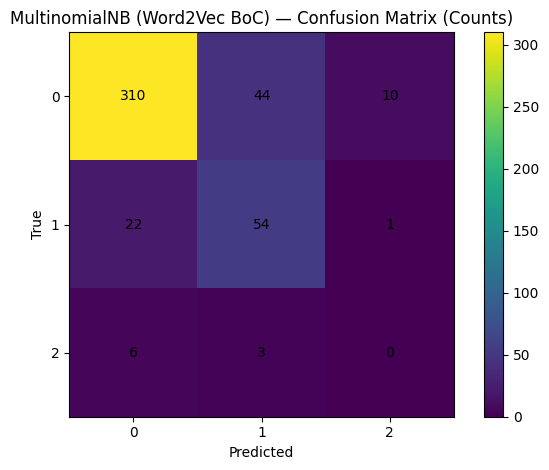

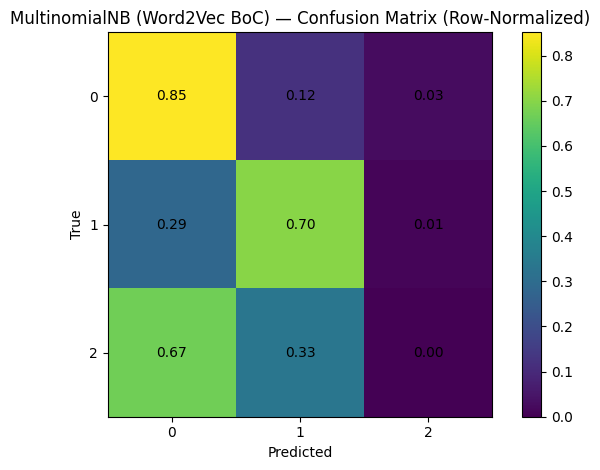

In [10]:
import os
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, log_loss, classification_report, confusion_matrix

BASE = "/content/drive/MyDrive/PR_Sky"

X_train = np.load(os.path.join(BASE, "lounge_X_train_boc.npy"))
X_test  = np.load(os.path.join(BASE, "lounge_X_test_boc.npy"))
y_train = np.load(os.path.join(BASE, "lounge_y_train.npy"))
y_test  = np.load(os.path.join(BASE, "lounge_y_test.npy"))

print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

alphas = [0.05, 0.1, 0.5, 1.0, 2.0]
best_alpha = None
best_acc = None
best_f1 = None
best_logloss = None
best_clf = None

i = 0
while i < len(alphas):
    a = alphas[i]
    clf = MultinomialNB(alpha=a)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    ll = log_loss(y_test, y_proba, labels=clf.classes_)
    if (best_logloss is None) or (ll < best_logloss):
        best_alpha = a
        best_acc = acc
        best_f1 = f1m
        best_logloss = ll
        best_clf = clf
    i = i + 1

print(f"\nBest alpha: {best_alpha}")
print(f"Accuracy  : {best_acc:.4f}")
print(f"Macro F1  : {best_f1:.4f}")
print(f"Log-loss  : {best_logloss:.4f}")

y_pred = best_clf.predict(X_test)
y_proba = best_clf.predict_proba(X_test)

print("\nClassification Report (best alpha):")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=best_clf.classes_)
print("\nConfusion Matrix (counts) [rows=true, cols=pred]:\n", cm)

try:
    import matplotlib.pyplot as plt

    plt.figure()
    plt.imshow(cm, interpolation='nearest'); plt.colorbar()
    plt.title("MultinomialNB (Word2Vec BoC) — Confusion Matrix (Counts)")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks(range(len(best_clf.classes_)), best_clf.classes_)
    plt.yticks(range(len(best_clf.classes_)), best_clf.classes_)
    ii = 0
    while ii < cm.shape[0]:
        jj = 0
        while jj < cm.shape[1]:
            plt.text(jj, ii, str(cm[ii, jj]), ha="center", va="center")
            jj = jj + 1
        ii = ii + 1
    plt.tight_layout(); plt.show()

    cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    plt.figure()
    plt.imshow(cmn, interpolation='nearest'); plt.colorbar()
    plt.title("MultinomialNB (Word2Vec BoC) — Confusion Matrix (Row-Normalized)")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks(range(len(best_clf.classes_)), best_clf.classes_)
    plt.yticks(range(len(best_clf.classes_)), best_clf.classes_)
    ii = 0
    while ii < cmn.shape[0]:
        jj = 0
        while jj < cmn.shape[1]:
            plt.text(jj, ii, f"{cmn[ii, jj]:.2f}", ha="center", va="center")
            jj = jj + 1
        ii = ii + 1
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Plotting skipped:", e)

# Path way to Bernoulli Naive Bayes

Feature Selection + Preprocessing to Binary Matrix

In [12]:
import os
import re
import csv
import json
import random
import numpy as np
from scipy.sparse import csr_matrix, save_npz

BASE = "/content/drive/MyDrive/PR_Sky"
IN_CSV = BASE + "/lounge_with_target.csv"
OUT_DIR = BASE
try:
    os.makedirs(OUT_DIR, exist_ok=True)
except:
    pass

rows = []
with open(IN_CSV, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    header = r.fieldnames
    for row in r:
        rows.append(row)

has_target = False
for col in header:
    if col == "satisfaction_class":
        has_target = True
        break
if not has_target:
    print("Run target creation first.")
    raise SystemExit(0)

clean = []
y_all = []
i = 0
while i < len(rows):
    v = rows[i].get("satisfaction_class", "")
    ok = True
    try:
        vv = float(v)
        if vv == int(vv):
            vv = int(vv)
        else:
            ok = False
    except:
        ok = False
    if ok and (vv == 0 or vv == 1 or vv == 2):
        rows[i]["satisfaction_class"] = vv
        clean.append(rows[i])
        y_all.append(vv)
    i = i + 1
rows = clean
y_all = np.array(y_all, dtype=np.int32)

CANDIDATES = [
    "type_traveller",
    "airport",
    "lounge_name",
    "lounge_type",
    "airline_name",
    "author_country",
]

present = []
for c in CANDIDATES:
    j = 0
    ok = False
    while j < len(header):
        if header[j] == c:
            ok = True
            break
        j = j + 1
    if ok:
        present.append(c)

if len(present) == 0:
    raise SystemExit(0)

print("Using categorical features:", present)

i = 0
while i < len(rows):
    for c in present:
        x = rows[i].get(c, "")
        is_missing = False
        if x is None:
            is_missing = True
        x = "" if x is None else str(x)
        x = x.strip().lower()
        x = re.sub(r"\s+", " ", x)
        if x == "" or is_missing:
            x = "unknown"
        rows[i][c] = x
    i = i + 1

TOPK = 50
top_sets = {}
for c in present:
    counts = {}
    i = 0
    while i < len(rows):
        v = rows[i][c]
        counts[v] = counts.get(v, 0) + 1
        i = i + 1

    items = list(counts.items())
    items.sort(key=lambda t: t[1], reverse=True)
    keep = []
    i = 0
    while i < len(items) and i < TOPK:
        keep.append(items[i][0])
        i = i + 1
    top_sets[c] = set(keep)

i = 0
while i < len(rows):
    for c in present:
        v = rows[i][c]
        if v not in top_sets[c]:
            rows[i][c] = "other"
    i = i + 1

col_values = {}
total_features = 0
feat_names = []
offsets = {}

start = 0
for c in present:
    seen = {}
    i = 0
    while i < len(rows):
        v = rows[i][c]
        seen[v] = True
        i = i + 1
    vals = list(seen.keys())
    vals.sort()
    col_values[c] = vals
    offsets[c] = start
    j = 0
    while j < len(vals):
        feat_names.append(c + "_" + str(vals[j]))
        j = j + 1
    total_features = total_features + len(vals)
    start = start + len(vals)

data = []
indices = []
indptr = [0]
i = 0
while i < len(rows):
    nnz_before = len(indices)
    for c in present:
        v = rows[i][c]
        vals = col_values[c]

        j = 0
        local_idx = -1
        while j < len(vals):
            if vals[j] == v:
                local_idx = j
                break
            j = j + 1
        if local_idx >= 0:
            indices.append(offsets[c] + local_idx)
            data.append(1)

    indptr.append(len(indices))
    i = i + 1

X_all_sparse = csr_matrix((np.array(data, dtype=np.uint8), np.array(indices, dtype=np.int32), np.array(indptr, dtype=np.int32)),
                          shape=(len(rows), total_features))

featmap_path = OUT_DIR + "/lounge_bnb_feature_names.json"
with open(featmap_path, "w", encoding="utf-8") as f:
    json.dump(feat_names, f, ensure_ascii=False, indent=2)

print("Binary matrix shape:", X_all_sparse.shape)
print("Saved feature names:", featmap_path)

idx0 = []
idx1 = []
idx2 = []
i = 0
while i < len(rows):
    yv = rows[i]["satisfaction_class"]
    if yv == 0:
        idx0.append(i)
    elif yv == 1:
        idx1.append(i)
    elif yv == 2:
        idx2.append(i)
    i = i + 1

random.seed(42)
random.shuffle(idx0)
random.shuffle(idx1)
random.shuffle(idx2)

def split_idx(lst):
    n = len(lst)
    n_test = int(n * 0.20)
    return lst[n_test:], lst[:n_test]

tr0, te0 = split_idx(idx0)
tr1, te1 = split_idx(idx1)
tr2, te2 = split_idx(idx2)

train_idx = tr0 + tr1 + tr2
test_idx  = te0 + te1 + te2

train_npz = OUT_DIR + "/lounge_BNB_X_train.npz"
test_npz  = OUT_DIR + "/lounge_BNB_X_test.npz"

X_tr = X_all_sparse[train_idx]
X_te = X_all_sparse[test_idx]
save_npz(train_npz, X_tr.tocsr())
save_npz(test_npz,  X_te.tocsr())

y_tr = y_all[train_idx]
y_te = y_all[test_idx]
np.save(OUT_DIR + "/lounge_BNB_y_train.npy", y_tr)
np.save(OUT_DIR + "/lounge_BNB_y_test.npy",  y_te)

print("\nSaved:")
print(" -", train_npz)
print(" -", test_npz)
print(" -", OUT_DIR + "/lounge_BNB_y_train.npy")
print(" -", OUT_DIR + "/lounge_BNB_y_test.npy")

Using categorical features: ['type_traveller', 'airport', 'lounge_name', 'lounge_type', 'airline_name', 'author_country']
Binary matrix shape: (2259, 214)
Saved feature names: /content/drive/MyDrive/PR_Sky/lounge_bnb_feature_names.json

Saved:
 - /content/drive/MyDrive/PR_Sky/lounge_BNB_X_train.npz
 - /content/drive/MyDrive/PR_Sky/lounge_BNB_X_test.npz
 - /content/drive/MyDrive/PR_Sky/lounge_BNB_y_train.npy
 - /content/drive/MyDrive/PR_Sky/lounge_BNB_y_test.npy


Train, Evaluate, Interpret

Shapes: (1809, 214) (450, 214) (1809,) (450,)

Best alpha: 1.5
Accuracy  : 0.7867
Macro F1  : 0.5394
Log-loss  : 0.5213

=== Classification Report (best alpha) ===
              precision    recall  f1-score   support

           0     0.8473    0.9148    0.8798       364
           1     0.3556    0.2078    0.2623        77
           2     0.4167    0.5556    0.4762         9

    accuracy                         0.7867       450
   macro avg     0.5399    0.5594    0.5394       450
weighted avg     0.7546    0.7867    0.7661       450


Confusion Matrix (counts) [rows=true, cols=pred]:
 [[333  26   5]
 [ 59  16   2]
 [  1   3   5]]


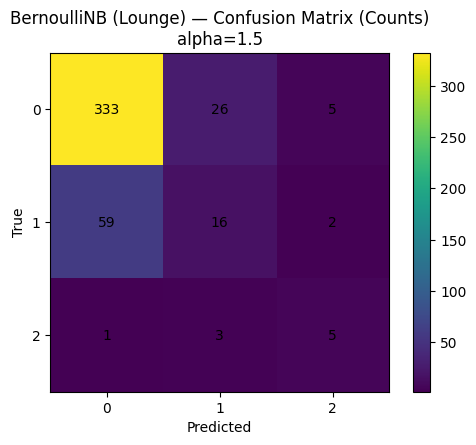

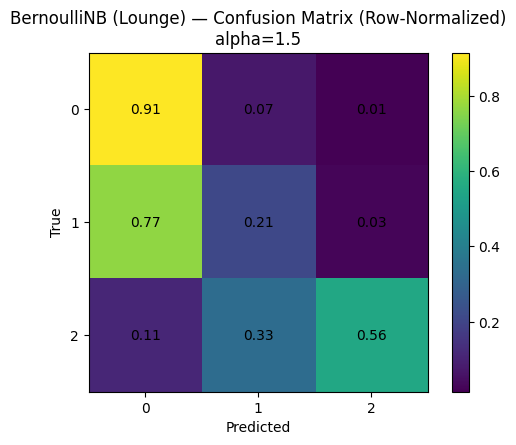


Top 15 features for class=0 (feat, logP(x=1|c), delta_vs_others):
  type_traveller_unknown                              -0.024   Δ=+1.424
  author_country_unknown                              -1.511   Δ=+1.003
  airline_name_united-airlines                        -2.658   Δ=+0.947
  lounge_type_unknown                                 -1.987   Δ=+0.716
  airport_rome fiumicino airport                      -3.903   Δ=+0.435
  airport_unknown                                     -3.137   Δ=+0.397
  airline_name_air-france                             -3.470   Δ=+0.219
  airline_name_delta-air-lines                        -3.448   Δ=+0.211
  lounge_name_american airlines admirals club lounge review  -4.131   Δ=+0.208
  lounge_name_united airlines red carpet club business class lounge review  -4.174   Δ=+0.164
  airport_chicago o'hare airport                      -3.806   Δ=+0.108
  airline_name_british-airways                        -2.197   Δ=+0.108
  lounge_type_business class            

In [13]:
import os
import json
import numpy as np
from scipy.sparse import load_npz
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, f1_score, log_loss, classification_report, confusion_matrix
import matplotlib.pyplot as plt

BASE = "/content/drive/MyDrive/PR_Sky"
XTR = os.path.join(BASE, "lounge_BNB_X_train.npz")
XTE = os.path.join(BASE, "lounge_BNB_X_test.npz")
ytr = os.path.join(BASE, "lounge_BNB_y_train.npy")
yte = os.path.join(BASE, "lounge_BNB_y_test.npy")
featmap_path = os.path.join(BASE, "lounge_bnb_feature_names.json")

X_train = load_npz(XTR)
X_test  = load_npz(XTE)
y_train = np.load(ytr)
y_test  = np.load(yte)

with open(featmap_path, "r", encoding="utf-8") as f:
    feature_names = json.load(f)

print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

alphas = [0.25, 0.5, 1.0, 1.5, 2.0]
best_alpha = None
best_acc = None
best_f1 = None
best_ll = None
best_clf = None

i = 0
while i < len(alphas):
    a = alphas[i]
    clf = BernoulliNB(alpha=a)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    ll = log_loss(y_test, y_proba, labels=clf.classes_)
    if (best_ll is None) or (ll < best_ll):
        best_alpha = a
        best_acc = acc
        best_f1 = f1m
        best_ll = ll
        best_clf = clf
    i = i + 1

print(f"\nBest alpha: {best_alpha}")
print(f"Accuracy  : {best_acc:.4f}")
print(f"Macro F1  : {best_f1:.4f}")
print(f"Log-loss  : {best_ll:.4f}")

y_pred = best_clf.predict(X_test)
y_proba = best_clf.predict_proba(X_test)

print("\n=== Classification Report (best alpha) ===")
print(classification_report(y_test, y_pred, digits=4))

classes = best_clf.classes_
cm = confusion_matrix(y_test, y_pred, labels=classes)
print("\nConfusion Matrix (counts) [rows=true, cols=pred]:\n", cm)

plt.figure(figsize=(5.5, 4.5))
plt.imshow(cm, interpolation="nearest")
plt.title(f"BernoulliNB (Lounge) — Confusion Matrix (Counts)\nalpha={best_alpha}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
ii = 0
while ii < cm.shape[0]:
    jj = 0
    while jj < cm.shape[1]:
        plt.text(jj, ii, str(cm[ii, jj]), ha="center", va="center")
        jj = jj + 1
    ii = ii + 1
plt.colorbar()
plt.tight_layout()
plt.show()

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(5.5, 4.5))
plt.imshow(cm_norm, interpolation="nearest")
plt.title(f"BernoulliNB (Lounge) — Confusion Matrix (Row-Normalized)\nalpha={best_alpha}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
ii = 0
while ii < cm_norm.shape[0]:
    jj = 0
    while jj < cm_norm.shape[1]:
        plt.text(jj, ii, f"{cm_norm[ii, jj]:.2f}", ha="center", va="center")
        jj = jj + 1
    ii = ii + 1
plt.colorbar()
plt.tight_layout()
plt.show()

log_prob = best_clf.feature_log_prob_
KSHOW = 15

i = 0
while i < len(classes):
    class_logp = log_prob[i]
    all_idx = np.arange(log_prob.shape[0])
    other_idx = np.delete(all_idx, i)
    mean_other = log_prob[other_idx].mean(axis=0)
    delta = class_logp - mean_other
    order = np.argsort(delta)[::-1][:KSHOW]

    print(f"\nTop {KSHOW} features for class={classes[i]} (feat, logP(x=1|c), delta_vs_others):")
    j = 0
    while j < len(order):
        feat_j = order[j]
        name = feature_names[feat_j]
        lp = float(class_logp[feat_j])
        dd = float(delta[feat_j])
        print(f"  {name:50s}  {lp:+.3f}   Δ={dd:+.3f}")
        j = j + 1
    i = i + 1

# Path way to Hybrid Model: Combining structured numeric and text features

LOAD DATASETS - numeric + text

In [14]:
import os
import re
import csv
import random
import numpy as np

BASE = "/content/drive/MyDrive/PR_Sky"
IN_CSV = BASE + "/lounge_with_target.csv"

rows = []
with open(IN_CSV, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    header = r.fieldnames
    for row in r:
        rows.append(row)

has_target = False
has_content = False
i = 0
while i < len(header):
    if header[i] == "satisfaction_class":
        has_target = True
    if header[i] == "content":
        has_content = True
    i = i + 1

if not has_target:
    print("Run target creation first.")
    raise SystemExit(0)
if not has_content:
    print("Missing text column 'content'.")
    raise SystemExit(0)

clean = []
i = 0
while i < len(rows):

    v = rows[i].get("satisfaction_class", "")
    ok = True
    try:
        vv = float(v)
        if vv == int(vv):
            vv = int(vv)
        else:
            ok = False
    except:
        ok = False

    txt = str(rows[i].get("content", "")).strip()

    if ok and (vv == 0 or vv == 1 or vv == 2) and (len(txt) > 0):
        rows[i]["satisfaction_class"] = vv
        rows[i]["content"] = txt
        clean.append(rows[i])
    i = i + 1
rows = clean

NUMERIC_FEATURES = [
    "comfort_rating","cleanliness_rating","bar_beverages_rating","catering_rating",
    "washrooms_rating","wifi_connectivity_rating","staff_service_rating",
]
present_num = []
for c in NUMERIC_FEATURES:
    j = 0
    found = False
    while j < len(header):
        if header[j] == c:
            found = True
            break
        j = j + 1
    if found:
        present_num.append(c)

if len(present_num) == 0:
    print("No numeric rating features found for GaussianNB hybrid branch.")
    raise SystemExit(0)

i = 0
while i < len(rows):
    for c in present_num:
        val = rows[i].get(c, "")
        try:
            rows[i][c] = float(val)
        except:
            rows[i][c] = None
    i = i + 1

_word_re = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?")

filtered = []
i = 0
while i < len(rows):
    text = str(rows[i]["content"]).lower()
    toks = _word_re.findall(text)
    if len(toks) > 0:
        rows[i]["tokens"] = toks
        filtered.append(rows[i])
    i = i + 1
rows = filtered

y = []
i = 0
while i < len(rows):
    y.append(rows[i]["satisfaction_class"])
    i = i + 1
y = np.array(y, dtype=np.int32)

idx_all = list(range(len(rows)))

idx0 = []
idx1 = []
idx2 = []
i = 0
while i < len(rows):
    if rows[i]["satisfaction_class"] == 0:
        idx0.append(i)
    elif rows[i]["satisfaction_class"] == 1:
        idx1.append(i)
    elif rows[i]["satisfaction_class"] == 2:
        idx2.append(i)
    i = i + 1

random.seed(42)
random.shuffle(idx0)
random.shuffle(idx1)
random.shuffle(idx2)

def split_idx(lst):
    n = len(lst)
    n_test = int(n * 0.20)
    te = lst[:n_test]
    tr = lst[n_test:]
    return tr, te

tr0, te0 = split_idx(idx0)
tr1, te1 = split_idx(idx1)
tr2, te2 = split_idx(idx2)

idx_tr = tr0 + tr1 + tr2
idx_te = te0 + te1 + te2

y_tr = []
i = 0
while i < len(idx_tr):
    y_tr.append(rows[idx_tr[i]]["satisfaction_class"])
    i = i + 1
y_tr = np.array(y_tr, dtype=np.int32)

y_te = []
i = 0
while i < len(idx_te):
    y_te.append(rows[idx_te[i]]["satisfaction_class"])
    i = i + 1
y_te = np.array(y_te, dtype=np.int32)

print("Total rows:", len(rows))
print("Train/Test:", len(idx_tr), len(idx_te))
print("Classes (train):", np.bincount(y_tr))
print("Classes (test) :", np.bincount(y_te))

df_tr = [rows[i] for i in idx_tr]
df_te = [rows[i] for i in idx_te]

Total rows: 2259
Train/Test: 1809 450
Classes (train): [1459  311   39]
Classes (test) : [364  77   9]


GAUSSIAN NB (numeric branch)

In [15]:
import math
import numpy as np

features = present_num

medians = []
i = 0
while i < len(features):
    col = features[i]
    vals = []
    j = 0
    while j < len(df_tr):
        v = df_tr[j].get(col, None)
        if v is not None:
            vals.append(float(v))
        j = j + 1
    vals.sort()
    if len(vals) == 0:
        med = 0.0
    else:
        n = len(vals)
        m = n // 2
        if n % 2 == 1:
            med = vals[m]
        else:
            med = (vals[m - 1] + vals[m]) / 2.0
    medians.append(med)
    i = i + 1

Xnum_tr_list = []
i = 0
while i < len(df_tr):
    row_vec = []
    j = 0
    while j < len(features):
        col = features[j]
        v = df_tr[i].get(col, None)
        if v is None:
            row_vec.append(medians[j])
        else:
            row_vec.append(float(v))
        j = j + 1
    Xnum_tr_list.append(row_vec)
    i = i + 1

Xnum_te_list = []
i = 0
while i < len(df_te):
    row_vec = []
    j = 0
    while j < len(features):
        col = features[j]
        v = df_te[i].get(col, None)
        if v is None:
            row_vec.append(medians[j])
        else:
            row_vec.append(float(v))
        j = j + 1
    Xnum_te_list.append(row_vec)
    i = i + 1

Xnum_tr = Xnum_tr_list
Xnum_te = Xnum_te_list

y_tr_list = []
i = 0
while i < len(df_tr):
    y_tr_list.append(int(df_tr[i]["satisfaction_class"]))
    i = i + 1
y_tr = np.array(y_tr_list, dtype=np.int32)

y_te_list = []
i = 0
while i < len(df_te):
    y_te_list.append(int(df_te[i]["satisfaction_class"]))
    i = i + 1
y_te = np.array(y_te_list, dtype=np.int32)

classes_num = [0, 1, 2]

by_class_idx = {0: [], 1: [], 2: []}
i = 0
while i < len(y_tr):
    c = int(y_tr[i])
    if c in by_class_idx:
        by_class_idx[c].append(i)
    i = i + 1

priors = {}
total = float(len(y_tr)) if len(y_tr) > 0 else 1.0
for c in classes_num:
    priors[c] = len(by_class_idx[c]) / total

means = {0: [], 1: [], 2: []}
vars_ = {0: [], 1: [], 2: []}

for c in classes_num:
    j = 0
    while j < len(features):

        s = 0.0
        cnt = 0
        k = 0
        while k < len(by_class_idx[c]):
            idx = by_class_idx[c][k]
            s = s + float(Xnum_tr[idx][j])
            cnt = cnt + 1
            k = k + 1
        mu = s / cnt if cnt > 0 else 0.0
        means[c].append(mu)

        s2 = 0.0
        k = 0
        while k < len(by_class_idx[c]):
            idx = by_class_idx[c][k]
            d = float(Xnum_tr[idx][j]) - mu
            s2 = s2 + d * d
            k = k + 1
        var = (s2 / cnt) if cnt > 0 else 1e-6
        if var <= 1e-9:
            var = 1e-9
        vars_[c].append(var)
        j = j + 1

y_pred_num_list = []
p_num_te_list = []

i = 0
while i < len(Xnum_te):

    logp = {}
    for c in classes_num:
        pr = priors[c]
        if pr <= 0.0:
            pr = 1e-12
        lp = math.log(pr)
        j = 0
        while j < len(features):
            x = float(Xnum_te[i][j])
            mu = means[c][j]
            var = vars_[c][j]
            lp = lp - 0.5 * math.log(2.0 * math.pi * var) - ((x - mu) * (x - mu)) / (2.0 * var)
            j = j + 1
        logp[c] = lp

    mlog = max(logp[0], logp[1], logp[2])
    e0 = math.exp(logp[0] - mlog)
    e1 = math.exp(logp[1] - mlog)
    e2 = math.exp(logp[2] - mlog)
    s = e0 + e1 + e2
    if s == 0.0:
        p0 = p1 = p2 = 1.0 / 3.0
    else:
        p0 = e0 / s
        p1 = e1 / s
        p2 = e2 / s
    p_num_te_list.append([p0, p1, p2])

    if p0 >= p1 and p0 >= p2:
        y_hat = 0
    elif p1 >= p0 and p1 >= p2:
        y_hat = 1
    else:
        y_hat = 2
    y_pred_num_list.append(y_hat)
    i = i + 1

p_num_te = np.array(p_num_te_list, dtype=float)
y_pred_num = np.array(y_pred_num_list, dtype=int)

correct = 0
i = 0
while i < len(y_te):
    if int(y_te[i]) == int(y_pred_num[i]):
        correct = correct + 1
    i = i + 1
acc_num = (correct / float(len(y_te))) if len(y_te) > 0 else 0.0

cm = [[0,0,0],[0,0,0],[0,0,0]]
i = 0
while i < len(y_te):
    a = int(y_te[i]); b = int(y_pred_num[i])
    if a >= 0 and a <= 2 and b >= 0 and b <= 2:
        cm[a][b] = cm[a][b] + 1
    i = i + 1

f1s = []
c = 0
while c < 3:
    tp = cm[c][c]
    col_sum = cm[0][c] + cm[1][c] + cm[2][c]
    row_sum = cm[c][0] + cm[c][1] + cm[c][2]
    fp = col_sum - tp
    fn = row_sum - tp
    if tp + fp > 0:
        prec = tp / float(tp + fp)
    else:
        prec = 0.0
    if tp + fn > 0:
        rec = tp / float(tp + fn)
    else:
        rec = 0.0
    if prec + rec > 0:
        f1c = 2.0 * prec * rec / (prec + rec)
    else:
        f1c = 0.0
    f1s.append(f1c)
    c = c + 1
f1m_num = (f1s[0] + f1s[1] + f1s[2]) / 3.0

eps = 1e-15
ll_sum = 0.0
i = 0
while i < len(y_te):
    t = int(y_te[i])
    p = float(p_num_te[i][t])
    if p < eps:
        p = eps
    ll_sum = ll_sum + (-math.log(p))
    i = i + 1
ll_num = (ll_sum / float(len(y_te))) if len(y_te) > 0 else 0.0

print("\n[GaussianNB] Test Acc: %.4f  MacroF1: %.4f  LogLoss: %.4f" % (acc_num, f1m_num, ll_num))



[GaussianNB] Test Acc: 0.8756  MacroF1: 0.6223  LogLoss: 0.6090


MULTINOMIAL NB (text branch: Word2Vec → KMeans BoC → MNB)

In [16]:
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, log_loss
import numpy as np

train_tokens = []
i = 0
while i < len(df_tr):
    train_tokens.append(df_tr[i]["tokens"])
    i = i + 1

test_tokens = []
i = 0
while i < len(df_te):
    test_tokens.append(df_te[i]["tokens"])
    i = i + 1

w2v_params = {"vector_size": 100, "window": 5, "min_count": 2, "workers": 4, "sg": 0, "epochs": 10}
w2v = Word2Vec(sentences=train_tokens, **w2v_params)

vocab = []
i = 0
while i < len(w2v.wv.index_to_key):
    vocab.append(w2v.wv.index_to_key[i])
    i = i + 1

print("Word2Vec vocab size:", len(vocab))

if len(vocab) > 0:

    vecs = []
    i = 0
    while i < len(vocab):
        vecs.append(w2v.wv[vocab[i]])
        i = i + 1
    word_vecs = np.vstack(vecs)

    K = len(vocab) // 5
    if K < 50:
        K = 50
    if K > 300:
        K = 300
    print("Clustering", len(vocab), "vectors into K=" + str(K) + " …")
    kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
    kmeans.fit(word_vecs)

    word2cluster = {}
    i = 0
    while i < len(vocab):
        word2cluster[vocab[i]] = int(kmeans.labels_[i])
        i = i + 1
else:

    K = 50
    word2cluster = {}
    print("Clustering", 0, "vectors into K=" + str(K) + " …")

def doc_to_boc(tokens, K, word2cluster):
    x = np.zeros(K, dtype=np.int32)
    i = 0
    while i < len(tokens):
        t = tokens[i]
        cid = word2cluster.get(t, -1)
        if cid >= 0:
            x[cid] = x[cid] + 1
        i = i + 1
    return x

Xtxt_tr_list = []
i = 0
while i < len(train_tokens):
    Xtxt_tr_list.append(doc_to_boc(train_tokens[i], K, word2cluster))
    i = i + 1
Xtxt_tr = np.vstack(Xtxt_tr_list) if len(Xtxt_tr_list) > 0 else np.zeros((0, K), dtype=np.int32)

Xtxt_te_list = []
i = 0
while i < len(test_tokens):
    Xtxt_te_list.append(doc_to_boc(test_tokens[i], K, word2cluster))
    i = i + 1
Xtxt_te = np.vstack(Xtxt_te_list) if len(Xtxt_te_list) > 0 else np.zeros((0, K), dtype=np.int32)

alphas = [0.05, 0.1, 0.5, 1.0, 2.0]
best_alpha = None
best_model = None
best_acc = None
best_f1 = None
best_ll = None

i = 0
while i < len(alphas):
    a = alphas[i]
    mnb = MultinomialNB(alpha=a)
    mnb.fit(Xtxt_tr, y_tr)
    p_txt_te = mnb.predict_proba(Xtxt_te)
    y_pred_txt = mnb.predict(Xtxt_te)
    acc = accuracy_score(y_te, y_pred_txt)
    f1m = f1_score(y_te, y_pred_txt, average="macro")
    ll = log_loss(y_te, p_txt_te, labels=mnb.classes_)
    if (best_ll is None) or (ll < best_ll):
        best_alpha = a
        best_model = mnb
        best_acc = acc
        best_f1 = f1m
        best_ll = ll
    i = i + 1

mnb = best_model
p_txt_te = mnb.predict_proba(Xtxt_te)
y_pred_txt = mnb.predict(Xtxt_te)

print("\n[MultinomialNB] Best alpha=%.3f  Acc: %.4f  MacroF1: %.4f  LogLoss: %.4f"
      % (best_alpha, best_acc, best_f1, best_ll))

classes_txt = mnb.classes_

Word2Vec vocab size: 4251
Clustering 4251 vectors into K=300 …

[MultinomialNB] Best alpha=2.000  Acc: 0.8000  MacroF1: 0.4881  LogLoss: 0.9143


HYBRID — combine GaussianNB (numeric) + MultinomialNB (text)


[HYBRID] Best w=0.25  Acc: 0.8733  MacroF1: 0.5641  LogLoss: 0.3954

=== Hybrid Classification Report (w=0.25) ===
              precision    recall  f1-score   support

           0     0.9757    0.8819    0.9264       364
           1     0.6486    0.9351    0.7660        77
           2     0.0000    0.0000    0.0000         9

    accuracy                         0.8733       450
   macro avg     0.5414    0.6056    0.5641       450
weighted avg     0.9002    0.8733    0.8804       450


Hybrid Confusion Matrix (counts) [rows=true, cols=pred]:
 [[321  33  10]
 [  5  72   0]
 [  3   6   0]]


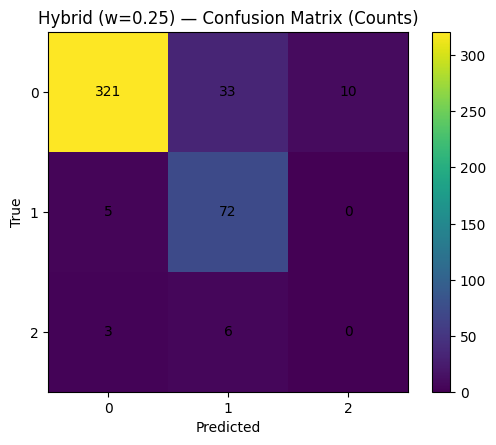

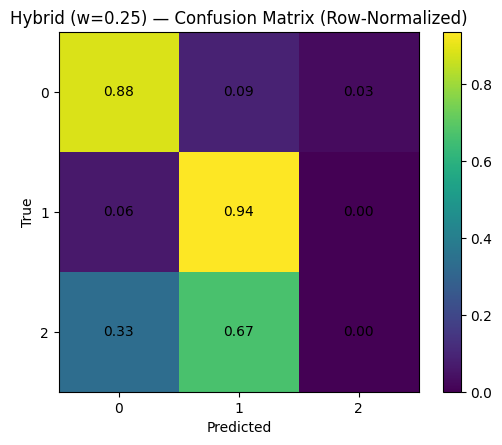

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, classification_report

classes = np.array(sorted(set(classes_num).intersection(set(classes_txt))))

m_num = {}
i = 0
while i < len(classes_num):
    m_num[classes_num[i]] = i
    i = i + 1

m_txt = {}
i = 0
while i < len(classes_txt):
    m_txt[classes_txt[i]] = i
    i = i + 1

p_num_aligned = np.zeros((p_num_te.shape[0], len(classes)), dtype=float)
j = 0
while j < len(classes):
    c = classes[j]
    idx = m_num[c]
    p_num_aligned[:, j] = p_num_te[:, idx]
    j = j + 1

p_txt_aligned = np.zeros((p_txt_te.shape[0], len(classes)), dtype=float)
j = 0
while j < len(classes):
    c = classes[j]
    idx = m_txt[c]
    p_txt_aligned[:, j] = p_txt_te[:, idx]
    j = j + 1

if p_num_aligned.shape[1] != len(classes) or p_txt_aligned.shape[1] != len(classes):
    raise RuntimeError("Class alignment failed for hybrid.")

weights = [0.00, 0.25, 0.50, 0.75, 1.00]
results = []

i = 0
while i < len(weights):
    w = weights[i]
    p_h = w * p_txt_aligned + (1.0 - w) * p_num_aligned

    y_pred_h = []
    r = 0
    while r < p_h.shape[0]:
        row = p_h[r]

        mi = 0
        k = 1
        while k < len(row):
            if row[k] > row[mi]:
                mi = k
            k = k + 1
        y_pred_h.append(classes[mi])
        r = r + 1
    y_pred_h = np.array(y_pred_h, dtype=int)

    acc = accuracy_score(y_te, y_pred_h)
    f1m = f1_score(y_te, y_pred_h, average="macro")
    ll  = log_loss(y_te, p_h, labels=classes)
    results.append((w, acc, f1m, ll))
    i = i + 1

best_w = None
best_acc = None
best_f1 = None
best_ll = None
i = 0
while i < len(results):
    w, acc, f1m, ll = results[i]
    if (best_ll is None) or (ll < best_ll):
        best_w = w
        best_acc = acc
        best_f1 = f1m
        best_ll = ll
    i = i + 1

print("\n[HYBRID] Best w=%.2f  Acc: %.4f  MacroF1: %.4f  LogLoss: %.4f" % (best_w, best_acc, best_f1, best_ll))

p_h_best = best_w * p_txt_aligned + (1.0 - best_w) * p_num_aligned

y_pred_h = []
r = 0
while r < p_h_best.shape[0]:
    row = p_h_best[r]
    mi = 0
    k = 1
    while k < len(row):
        if row[k] > row[mi]:
            mi = k
        k = k + 1
    y_pred_h.append(classes[mi])
    r = r + 1
y_pred_h = np.array(y_pred_h, dtype=int)

print("\n=== Hybrid Classification Report (w=%.2f) ===" % best_w)
print(classification_report(y_te, y_pred_h, digits=4))

cm = confusion_matrix(y_te, y_pred_h, labels=classes)
print("\nHybrid Confusion Matrix (counts) [rows=true, cols=pred]:\n", cm)

plt.figure(figsize=(5.5, 4.5))
plt.imshow(cm, interpolation="nearest")
plt.title("Hybrid (w=%.2f) — Confusion Matrix (Counts)" % best_w)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
i = 0
while i < cm.shape[0]:
    j = 0
    while j < cm.shape[1]:
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
        j = j + 1
    i = i + 1
plt.colorbar(); plt.tight_layout(); plt.show()

cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(5.5, 4.5))
plt.imshow(cmn, interpolation="nearest")
plt.title("Hybrid (w=%.2f) — Confusion Matrix (Row-Normalized)" % best_w)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
i = 0
while i < cmn.shape[0]:
    j = 0
    while j < cmn.shape[1]:
        plt.text(j, i, "%.2f" % (cmn[i, j]), ha="center", va="center")
        j = j + 1
    i = i + 1
plt.colorbar(); plt.tight_layout(); plt.show()